In [1]:
import math
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from model import Net
from preprocessor import CorpusPreprocessor
from dataset import CorpusDataset

In [2]:
DATA_FILE = 'corpus.pt'
MODEL_FILE = 'checkpoint.pt'
DEVICE = 'cuda:0'

cp = CorpusPreprocessor()
cp.load(DATA_FILE)
_, dataset = CorpusDataset.split(cp, 0.8)

net = Net(len(cp.alphabet), cp.max_sentence_length, cp.max_word_length)
net.load_state_dict(torch.load(MODEL_FILE, map_location=DEVICE))
net.to(DEVICE)
we = net.we

Obliczmy embeddingi dla wszystkich słów:

In [3]:
embs = dict()
for w in cp.words:
    with torch.no_grad():
        t = dataset.word2tensor(w).to(DEVICE).unsqueeze(0)
        embs[w] = we(t).squeeze(0).cpu()

## Wizualizacja

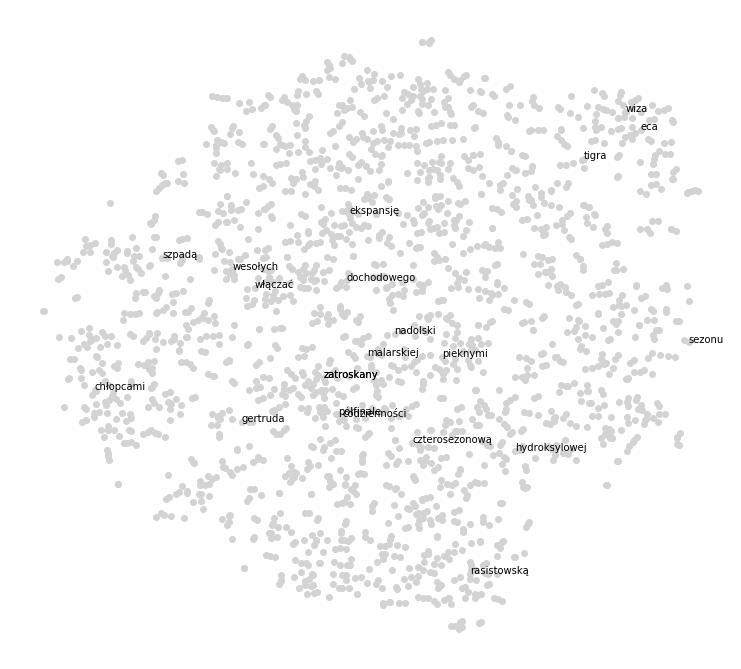

In [5]:
mywords = random.sample(cp.words, 20)
tsne_words = mywords + random.sample(cp.words, 2000)
tsne_embs = torch.stack(tuple(embs[w] for w in tsne_words)).numpy()
tsne = TSNE(perplexity=15, n_components=2).fit_transform(tsne_embs)

plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9, wspace=0.0, hspace=0.0)

xs = list(tsne[:, 0])
ys = list(tsne[:, 1])
plt.scatter(xs, ys, c='lightgrey')
for x, y, w in zip(xs, ys, tsne_words):
    if w in mywords:
        ax.annotate(w, (x, y))

## Podobne słowa
Znajdźmy słowa najbardziej podobne do wybranych (najbliższe w sensie odległości między wektorami)

In [6]:
for mw in mywords:
    print(mw)
    dists = []
    for w in cp.words:
        if w == mw:
            continue
        dist = torch.sqrt(torch.sum((embs[mw] - embs[w]) ** 2)).item()
        dists.append((w, dist))
    dists = sorted(dists, key=lambda x: x[1])
    for w, d in dists[:10]:
        print(f'  {w:<15} {d}')

eca
  ec              2.61696457862854
  eco             3.4048891067504883
  eq              3.7342941761016846
  vce             3.924884557723999
  ecs             4.197074890136719
  ema             4.19964599609375
  eve             4.203695297241211
  aca             4.374002933502197
  vc              4.471709728240967
  ecw             4.519515514373779
włączać
  włączyć         1.1892201900482178
  odkopuję        1.2064521312713623
  przedłużą       1.2763755321502686
  wyczekiwać      1.296106219291687
  wyszukiwać      1.3187391757965088
  kozactwa        1.330886721611023
  zdobyto         1.34232759475708
  odmóżdżyć       1.3527323007583618
  brusztyn        1.3658000230789185
  wymiatano       1.3963299989700317
chłopcami
  chcopcami       1.318110704421997
  drgawkami       1.4475934505462646
  stolicami       1.4909882545471191
  bojkotami       1.5406254529953003
  serialem        1.6204856634140015
  ozdobnymi       1.6885802745819092
  lisówkami       1.68996214866

## Relacje semantyczne

In [7]:
testpairs = [
    ('warszawa', 'polska', 'paryż', 'francja'),
    ('niemcy', 'berlin', 'rosja', 'moskwa'),
    ('stół', 'stołu', 'dom', 'domu'),
    ('król', 'mężczyzna', 'królowa', 'kobieta'),
    ('tata', 'mężczyzna', 'mama', 'kobieta'),
    ('on', 'mężczyzna', 'ona', 'kobieta'),
    ('ciepło', 'lato', 'zimno', 'zima'),
    ('ciemno', 'noc', 'jasno', 'dzień'),
    ('samochód', 'koła', 'samolot', 'skrzydła'),
    ('ojciec', 'mężczyzna', 'jezioro', 'ciasto'),
    ('pis', 'kaczyński', 'po', 'tusk'),
    ('samochód', 'samochodem', 'rower', 'roweru'),
    ('samochód', 'samochodem', 'rower', 'rowerem'),
    ('ciasto', 'ciasta', 'kobieta', 'kobiety'),
]

dists = []

for pair in testpairs:
    dist = torch.sqrt(torch.sum(((embs[pair[0]] - embs[pair[1]]) - (embs[pair[2]] - embs[pair[3]])) ** 2)).item()
    dists.append((pair, dist))

for pair, dist in sorted(dists, key=lambda p: p[1]):
    print(f'W({pair[0]:^10}) - W({pair[1]:^10}) ≃ W({pair[2]:^10}) - W({pair[3]:^10}) : {dist}')

W(  ciasto  ) - W(  ciasta  ) ≃ W( kobieta  ) - W( kobiety  ) : 3.203430652618408
W( samochód ) - W(samochodem) ≃ W(  rower   ) - W(  roweru  ) : 3.9583475589752197
W(   stół   ) - W(  stołu   ) ≃ W(   dom    ) - W(   domu   ) : 4.669485092163086
W(   tata   ) - W(mężczyzna ) ≃ W(   mama   ) - W( kobieta  ) : 4.907070636749268
W(   król   ) - W(mężczyzna ) ≃ W( królowa  ) - W( kobieta  ) : 5.244370937347412
W(    on    ) - W(mężczyzna ) ≃ W(   ona    ) - W( kobieta  ) : 5.339933395385742
W( samochód ) - W(   koła   ) ≃ W( samolot  ) - W( skrzydła ) : 5.549585342407227
W( samochód ) - W(samochodem) ≃ W(  rower   ) - W( rowerem  ) : 5.566159725189209
W(  ojciec  ) - W(mężczyzna ) ≃ W( jezioro  ) - W(  ciasto  ) : 6.1089091300964355
W(  niemcy  ) - W(  berlin  ) ≃ W(  rosja   ) - W(  moskwa  ) : 6.1406450271606445
W( warszawa ) - W(  polska  ) ≃ W(  paryż   ) - W( francja  ) : 7.674525737762451
W(  ciepło  ) - W(   lato   ) ≃ W(  zimno   ) - W(   zima   ) : 8.22922420501709
W(  ciemno  ) 